# Project 4: Pretraining

This is the fourth project in NLP SW010 done by Jannine Meier. 

The project was run on GPUHub.

WandB Project Link with created View options: https://wandb.ai/nlp_janninemeier/project4_JM?nw=nwuserjanninemeier

### Project description
This project explores the application of a pretrained transformer encoder model with a randomly initialized single layer classifier, specifically the Huggingface's BertForSequenceClassification, to solve two distinct language-based challenges:
- The Winogrande challenge which involves selecting the correct option to fill in a blank in a given sentence from two choices. 
- The anagram detection which is a problem where the task is to identify whether two strings are anagrams of each other. 

## Libraries & Imports

In [ ]:
# Install libraries
!pip install numpy pandas torch datasets transformers wandb matplotlib scikit-learn seaborn 

In [ ]:
import os
import wandb
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from datasets import load_dataset, Dataset as HFDataset
from transformers import (BertTokenizer, BertForSequenceClassification, Trainer,
                          TrainingArguments, TrainerCallback, EarlyStoppingCallback)


# Set seed for reproducibility across modules
def set_seed(seed_value):
    random.seed(seed_value)  # Python
    np.random.seed(seed_value)  # NumPy
    torch.manual_seed(seed_value)  # PyTorch
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)  # PyTorch, if CUDA is available

set_seed(42)

## Preprocessing 

**Load Datasets:** I load and split the datasets into training, validation, and test sets. For the Winogrande dataset, I specifically extracted the last 1000 entries from the training dataset to create the test set. 
**BERT Tokenizer Usage:** As I decided to use the BERT model for this project, utilizing the Bert tokenizer is essential to convert input text into a format that the model can understand.
**Uncased Variant:** I chose the uncased variant of the BERT tokenizer because it treats words identically regardless of their case. This helps in reducing the model's complexity and improves its ability to generalize across different text inputs.

#### Winogrande Specific Preprocessing Steps

- **Not Removing Punctuation and Stopwords:** I decided to retain punctuation and stopwords because they sometimes have significant contextual meanings which might be crucial for the model to understand nuanced differences between sentences.
- **No Stemming or Lemmatization:** I decided that these processes are unnecessary for BERT, which uses a WordPiece tokenization method capable of understanding various word forms without reducing them to their root forms.
- **Sequence Preparation:** I replace the placeholder `_` with each answer option to create distinct scenarios for the model, concatenate them and add a separator token between the two constructed sentences.
- **Token ID Conversion and Special Tokens:** The sequences are converted into token IDs, with `[CLS]` tokens at the start and `[SEP]` tokens at the end. The [CLS] token serves as the basis for classification decisions later on.
- **Padding and Truncation:** To handle different sequence lengths uniformly, I fixed the padding length to 85 (which is the max_length considering all three datasets) across all batches after encountering issues with batch-specific padding. I chose to pad to max_length to ensures that no information is lost from the inputs. 
- **Attention Masks Generation:** I generate attention masks to help the model focus on meaningful tokens and ignore padded areas, enhancing model efficiency and focus.
- **Labels:** Labels are assigned based on the correct answer provided in the dataset (0 if 'answer' is '1', meaning the first option is correct, and 1 otherwise)
- **Decoded example sequence:** `[CLS] ian volunteered to eat dennis's menudo after already having a bowl because ian despised eating intestine. [SEP] ian volunteered to eat dennis's menudo after already having a bowl because dennis despised eating intestine. [SEP] [PAD] ... [PAD]` 


#### Anagram Specific Preprocessing Steps

- **No Standardization/Normalization Needed:** The Anagram datasets are already clean (e.g., lowercased, single characters), which eliminated the need for additional text normalization.
- **Replacing SEP Token:** I replace `<sep>` in each sequence with the BERT separator token to standardize the input format for the tokenizer to handle it correctly.
- **Token ID Conversion and Special Tokens:** Like in the Winogrande preprocessing, I convert sequences into token IDs with `[CLS]` and `[SEP]` tokens at appropriate places to ensure that the model processes each input correctly.
- **Padding and Truncation:** I ensured uniform sequence lengths across each batch by batching to max_length (here done "correctly" per batch - no workaround like for the winogrande), preventing loss of important data.
- **Attention Masks Generation:** I generate attention masks to help the model focus on meaningful tokens and ignore padded areas, enhancing model efficiency and focus.
- **Labels:** Labels are assigned based on whether the sequences form anagrams or not (0 if sequence is an anagram, and 1 otherwise).
- **Decoded example sequence:** `[CLS] v l x [SEP] l x v [SEP] [PAD] ... [PAD]`

In [3]:
# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [4]:
# Calculate maximum length across all splits
def find_max_length_overall(dataset_name):
    
    # **************************************************************************************************
    # This is the workaround described for Winogrande because doing padding batchwise (setting padding = True for the tokenizer) was throwing an error.
    # Only needs to be run once to find max_length of 85 but I left the code for documentation.
    # **************************************************************************************************
   
    # Load the dataset with the specific subset or configuration
    dataset = load_dataset("winogrande", dataset_name)

    max_length = 0

    # Iterate over each split in the dataset
    for split in dataset.keys():
        for example in dataset[split]:
            # Construct the input by replacing the blank with both options and adding a separator token
            input_option1 = example['sentence'].replace('_', example['option1']) + tokenizer.sep_token
            input_option2 = example['sentence'].replace('_', example['option2'])
            combined_input = input_option1 + input_option2

            # Tokenize the combined input and add special tokens
            tokenized_input = tokenizer.encode(combined_input, add_special_tokens=True)

            # Update max_length if the current length is greater
            if len(tokenized_input) > max_length:
                max_length = len(tokenized_input)

    return max_length

# Specify the specific subset or configuration of the dataset
dataset_config = 'winogrande_l'
max_length = find_max_length_overall(dataset_config)
print(f"The maximum sequence length across all splits of the Winogrande dataset configuration '{dataset_config}' is: {max_length}")


The maximum sequence length across all splits of the Winogrande dataset configuration 'winogrande_l' is: 85


In [5]:
#  Preprocess winogrande dataset
def load_and_process_dataset(dataset_name, split_type):
    
    # Load the dataset based on the provided name and splits (train, validation, test)
    dataset = load_dataset(dataset_name, split_type)

    # Define a function to process each batch of data
    def process_batch(examples):
        # Create combined sentences by replacing the underscore with two options
        combined_sentences = [
            s.replace('_', option1) + tokenizer.sep_token + s.replace('_', option2)
            for s, option1, option2 in zip(examples['sentence'], examples['option1'], examples['option2'])
        ]
        # Tokenize the combined sentences, adding special tokens, and manage padding and truncation
        tokenized_outputs = tokenizer(
            combined_sentences,
            add_special_tokens=True, 
            padding="max_length", 
            max_length=85, 
            truncation=True, # As sequences are padded to max_length this setting does not actually make a difference
            return_tensors="pt"
        )
        
        # Generate labels for the sentences (0 if first option is correct, 1 if second option is correct)
        labels = [0 if a == '1' else 1 for a in examples['answer']]
        
        # Return the tokenized sentences along with their corresponding labels and attention masks
        return {
            'input_ids': tokenized_outputs['input_ids'],
            'attention_mask': tokenized_outputs['attention_mask'],
            'labels': torch.tensor(labels, dtype=torch.long)
        }

    # Process the dataset by applying the `process_batch` function to each split
    processed_datasets = {
        split: dataset[split].map(process_batch, batched=True, remove_columns=dataset[split].column_names)
        for split in ['train', 'validation', 'test']
    }
    # Return the processed dataset
    return processed_datasets

In [6]:
# Preprocess anagram dataset
def load_and_tokenize_anagram(base_path, size):
    
    # Inner function to load and process each CSV file
    def load_and_process(csv_path):
        # Load the CSV file as a DataFrame without headers and name the columns
        df = pd.read_csv(csv_path, header=None, names=['sequence', 'label'])
        
        # Replace the '<sep>' token in sequences with the tokenizer's sep_token
        sequences = [seq.replace('<sep>', tokenizer.sep_token) for seq in df['sequence']]
        
        # Tokenize the sequences, adding special tokens, and manage padding and truncation
        tokenized_outputs = tokenizer(
            sequences, 
            add_special_tokens=True, 
            padding=True, 
            truncation=True # As sequences are padded to max_length per batch this setting does not actually make a difference
        )
        
        # Create a HuggingFace Dataset from the tokenized data and labels
        return HFDataset.from_dict({
            'input_ids': tokenized_outputs['input_ids'],
            'attention_mask': tokenized_outputs['attention_mask'],
            'labels': df['label'].astype(int)
        })

    # Define paths to the training, validation, and testing CSV files
    paths = {
        'train': os.path.join(base_path, f'anagram_{size}_train.csv'),
        'validation': os.path.join(base_path, f'anagram_{size}_valid.csv'),
        'test': os.path.join(base_path, f'anagram_{size}_test.csv')
    }

    # Load and process datasets for each split (train, validation, test)
    datasets = {split: load_and_process(paths[split]) for split in paths.keys()}
    return datasets


base_path = 'NLP/SW08'

In [7]:
# Define the dataset to load and use for model
dataset_choice = 'wg'  # choose 'wg', 'as', or 'al'

if dataset_choice == 'wg':

    winogrande_datasets = load_and_process_dataset('winogrande', 'winogrande_l')

    train_dataset = winogrande_datasets['train'].select(range(len(winogrande_datasets['train']) - 1000))
    eval_dataset = winogrande_datasets['validation']
    test_dataset = winogrande_datasets['train'].select(range(len(winogrande_datasets['train']) - 1000, len(winogrande_datasets['train'])))

    # Print and decode first two examples from each winogrande split
    def print_decoded_examples(processed_data, num_examples=2):
        for split in processed_data:
            print(f"--- {split.upper()} SET ---")
            dataset_split = processed_data[split]
            for i in range(min(num_examples, len(dataset_split))):
                # Decode the entire input_ids for both options
                print("Combined Options:", tokenizer.decode(dataset_split[i]['input_ids']))
                # Correct label access
                print("Label:", "Option 1 is correct" if dataset_split[i]['labels'] == 0 else "Option 2 is correct")
                print()

    print("Winogrande decoded preprocessing output")
    print()
    print_decoded_examples(winogrande_datasets)


elif dataset_choice == 'al' or dataset_choice == 'al':

    # Print and decode first two examples from each anagram split
    def print_decoded_examples(anagram_datasets, num_examples=2):
        for split in anagram_datasets:
            print(f"--- {split.upper()} SET ---")
            df = anagram_datasets[split].to_pandas()
            for i in range(min(num_examples, len(anagram_datasets[split]))):
                sequence = tokenizer.decode(anagram_datasets[split][i]['input_ids'])
                print(f"Sequence {i+1}: {sequence}")
                print(f"Label: {df.at[i, 'labels']}")
                print()

    if dataset_choice == 'as':
        # Load small anagram datasets
        anagram_datasets = load_and_tokenize_anagram(base_path, size='small')

        train_dataset = anagram_datasets['train']
        eval_dataset = anagram_datasets['validation']
        test_dataset = anagram_datasets['test']
        
        print("Anagram small decoded preprocessing output")
        print()
        print_decoded_examples(anagram_datasets)

    elif dataset_choice == 'al':
        # Load large anagram datasets
        anagram_datasets = load_and_tokenize_anagram(base_path, size='large')

        train_dataset = anagram_datasets['train']
        eval_dataset = anagram_datasets['validation']
        test_dataset = anagram_datasets['test']

        print("Anagram large decoded preprocessing output")
        print()
        print_decoded_examples(anagram_datasets)

Winogrande decoded preprocessing output

--- TRAIN SET ---
Combined Options: [CLS] ian volunteered to eat dennis's menudo after already having a bowl because ian despised eating intestine. [SEP] ian volunteered to eat dennis's menudo after already having a bowl because dennis despised eating intestine. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Label: Option 2 is correct

Combined Options: [CLS] ian volunteered to eat dennis's menudo after already having a bowl because ian enjoyed eating intestine. [SEP] ian volunteered to eat dennis's menudo after already having a bowl because dennis enjoyed eating intestine. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

## Model
I've chosen to use the `BertForSequenceClassification` model.

#### Model Architecture: BERT
- **Pre-trained Knowledge**: I chose BERT because it’s been trained on tons of text already so it already knows a lot about language, which is very useful for the Winogrande task where we need to get the nuances of sentences to figure out the right answers.
- **Bidirectional Contextual Understanding**: What's nice about BERT is that it considers both the words before and after the target word in the sentence. This is perfect for Winogrande because the meaning of a sentence can change a lot depending on the words around the blanks we're trying to fill.

#### Customizing for Sequence Classification
- **Fine-Tuning for Our Specific Need**: While BERT is generally about understanding language, BertForSequenceClassification tweaks it to classify sequences into categories. For Winogrande, this means deciding if a sentence makes sense with one word or another, which is exactly what I want to achieve.

#### Input and Output
- **Input**: Inputs to the model are the ouputs from preprocessing so input IDs, attention masks and labels.
- **Output**: It gives back logits for both classes, which are basically raw predictions that tell us how confident the model is about each word choice. I then determine the predicted class label by selecting the index (class) with the highest score.


#### Loss Function and Optimization Strategy
- **Cross-Entropy Loss**: I chose this (defaulted) loss function because it measures the discrepancy between predicted probabilities and the actual labels effectively. This metric is directly tied to enhancing prediction accuracy in a classification setting like Winogrande, where choosing the correct entity is the goal.
- **AdamW Optimizer**: I used AdamW to manage model training as it integrates Adam’s effective optimization capabilities with a mechanism for better weight management (a variant with weight decay fix). This choice helps stabilize training on the nuanced Winogrande dataset, mitigating issues like gradient fluctuation.

In [ ]:
# Load a pre-trained Bert model for sequence classification with 2 classes (binary classification)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

In [9]:
# Set up the computing device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define a function to compute metrics
def compute_metrics(pred):
    # Extract label IDs and predictions from the model's output
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)  # Determine the class with the highest probability
    accuracy = accuracy_score(labels, preds)  # Calculate the accuracy of predictions
    
    # Check if loss is calculated and accessible in the predictions
    if hasattr(pred, 'loss'):
        loss = pred.loss.item()  # Convert the tensor to a Python float
    else:
        loss = None  # If loss is not calculated, return None
    
    # Return the metrics as a dictionary
    return {
        'eval_accuracy': accuracy,  # Evaluation accuracy
        'eval_loss': loss  # Evaluation loss (included if computed)
    }

# Define a callback class for detailed logging during evaluation phases
class DetailedLoggingCallback(TrainerCallback):
    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        # Log validation metrics to wandb
        if metrics:
            wandb.log({
                "validation/accuracy": metrics.get('eval_accuracy', 0),  
                "validation/loss": metrics.get('eval_loss', 0), 
                "step": state.global_step  
            })

# Custom Trainer class to handle training steps, including moving data to GPU and logging
class CustomTrainer(Trainer):
    def training_step(self, model, inputs):
        model.train()  # Set the model to training mode
        inputs = {k: v.to(device) for k, v in inputs.items()}  # Move input tensors to the configured device

        outputs = model(**inputs)  # Forward pass
        loss = outputs.loss  # Extract loss from the model outputs
        logits = outputs.logits  # Extract logits for calculating predictions

        predictions = logits.argmax(-1)  # Determine the predicted class
        train_accuracy = accuracy_score(inputs['labels'].cpu().numpy(), predictions.cpu().numpy())  # Calculate training accuracy

        # Log training accuracy and loss to wandb
        wandb.log({"train/accuracy": train_accuracy, "train/loss": loss.item(), "step": self.state.global_step})

        self.optimizer.zero_grad()  # Reset gradients
        loss.backward()  # Compute gradient of the loss wrt model parameters
        self.optimizer.step()  # Update model parameters

        return loss  

## Training & Evaluation

- I set up the model to log every 10 steps. 
- I used the largest batch sizes that the system could handle without running into memory errors.
- For Winogrande, I settled on 10 epochs because this task involves complex language understanding that might start overfitting if trained for too long due to its nuanced dataset (and also due to time constraints). For the Anagram task, I chose 100 epochs given the generally simpler nature of the task and shorter texts.
- I perform warm-up for the first 10% of the training. I chose a ratio instead of fixed steps as it maintains a consistent proportion of the training dedicated to warmup regardless of the total number of steps or epochs.
- I chose a fixed weight decay of 0.01 to help regularize the model and prevent overfitting.
- I stop training if there is no improvement in 20 evaluations to not only save time but also avoid overfitting.

#### Sweep configuration

- **Method:** I use a grid search approach, where all combinations of the provided hyperparameter values are evaluated because I only have few parameters.
- **Learning Rates:** I use learning rates ranging from 1e-6 to 1e-2, covering a broad spectrum from very slow to relatively fast learning to maximize the evaluation accuracy. 


In [10]:
# Sweep configuration
sweep_config = {
    'method': 'grid', 
    'metric': {
        'name': 'eval_accuracy',
        'goal': 'maximize'   
    },
    'parameters': {
        'learning_rate': {'values': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]}
    }
}

In [ ]:
# Set the environment variable for wandb to ensure model checkpoints are logged
os.environ["WANDB_LOG_MODEL"] = "checkpoint"

# Initialize and execute the model training
def train():
    wandb.init()

    # Move the model to the GPU if CUDA is available, else to CPU
    model.to(device) 

    # Define training arguments and hyperparameters
    training_args = TrainingArguments(
        output_dir='./results_project4',  
        evaluation_strategy="steps",  
        eval_steps=10,  # Evaluate the model every 10 steps
        logging_steps=10,  
        learning_rate=wandb.config.learning_rate,  # Use learning rate from sweep configuration
        per_device_train_batch_size=32,  
        per_device_eval_batch_size=64, 
        num_train_epochs=10, 
        weight_decay=0.01,  
        logging_dir='./logs',  
        report_to="wandb",  
        run_name="training-run", 
        load_best_model_at_end=True,  # Load the best model at the end of training based on `metric_for_best_model`
        metric_for_best_model='eval_accuracy',  
        save_strategy="steps", 
        warmup_ratio=0.1  # Perform warm-up for the first 10% of the training
    )

    # Create an instance of the custom trainer class
    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,  
        eval_dataset=eval_dataset,  
        compute_metrics=compute_metrics,  
        callbacks=[
            DetailedLoggingCallback(),  # Custom callback for detailed logging
            EarlyStoppingCallback(early_stopping_patience=20) 
        ]
    )

    # Start training
    trainer.train()
    # Finish training
    wandb.finish()

# Start runs with the train function using the sweep configuration
sweep_id = wandb.sweep(sweep_config, project="project4_JM") 
wandb.agent(sweep_id, train, count=5) 

## Results

In [11]:
# Evaluation method for printing results and confusion matrix
def evaluate_model(eval_dataset, test_dataset, compute_metrics, artifact_dir):
    # Load the model from the downloaded artifact (best model)
    model = BertForSequenceClassification.from_pretrained(artifact_dir)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Setup training arguments for evaluation
    training_args = TrainingArguments(
        output_dir='./results',
        per_device_eval_batch_size=64,
        do_train=False,
        do_eval=True,
        no_cuda=not torch.cuda.is_available()
    )

    # Initialize the Trainer for validation
    trainer = Trainer(
        model=model,
        args=training_args,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics
    )

    # Evaluate on validation dataset to get validation accuracy
    validation_results = trainer.evaluate(eval_dataset)
    print("Validation Accuracy:", validation_results['eval_accuracy'])

    # Predict on the validation dataset for confusion matrix
    val_predictions_output = trainer.predict(eval_dataset)
    val_predictions = np.argmax(val_predictions_output.predictions, axis=1)
    val_true_labels = val_predictions_output.label_ids

    # Compute and display the confusion matrix for validation set
    val_conf_matrix = confusion_matrix(val_true_labels, val_predictions)
    fig, ax = plt.subplots(figsize=(5, 5))
    disp_val = ConfusionMatrixDisplay(confusion_matrix=val_conf_matrix)
    disp_val.plot(cmap=plt.cm.Blues, ax=ax)
    plt.title('Confusion Matrix for Validation Set')
    plt.show()

    # Initialize the Trainer for testing
    trainer = Trainer(
        model=model,
        args=training_args,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics
    )

    # Predict on the test dataset
    test_results = trainer.predict(test_dataset)
    test_preds = np.argmax(test_results.predictions, axis=1)

    # Calculate and print test accuracy
    test_accuracy = accuracy_score(test_results.label_ids, test_preds)
    print("Test Accuracy:", test_accuracy)

    # Compute and display the confusion matrix for test set
    test_conf_matrix = confusion_matrix(test_results.label_ids, test_preds)
    fig, ax = plt.subplots(figsize=(5, 5))
    disp_test = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix)
    disp_test.plot(cmap=plt.cm.Blues, ax=ax)
    plt.title('Confusion Matrix for Test Set')
    plt.show()

#### Winogrande 
Best learning rate configuration was 1e-5. This is the red run in wandb.

wandb: Downloading large artifact model-ancient-sweep-2:v0, 417.68MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:0.9


Validation Accuracy: 0.55327545382794


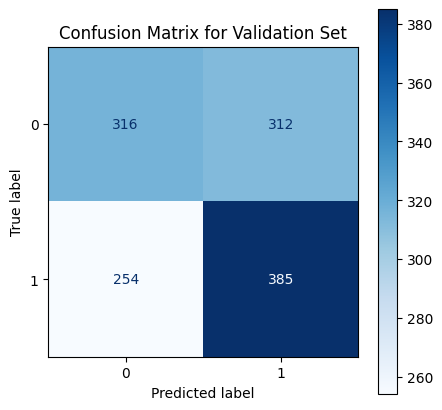

Test Accuracy: 0.662


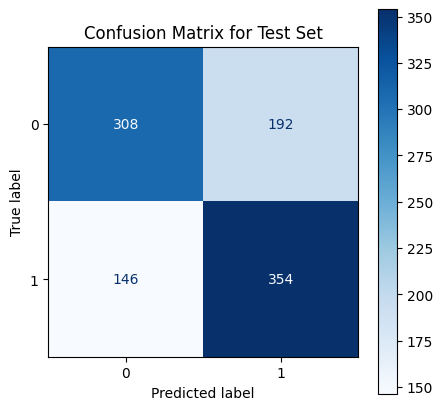

In [13]:
# Initialize wandb API client and download the model artifact
api = wandb.Api()
artifact_full_path = "nlp_janninemeier/project4_JM/model-ancient-sweep-2:v0"
artifact = api.artifact(artifact_full_path, type='model')
artifact_dir = artifact.download()

evaluate_model(eval_dataset, test_dataset, compute_metrics, artifact_dir)

#### Anagram Small
Best learning rate configuration was 1e-6. This is the blue run in wandb.

wandb: Downloading large artifact model-divine-sweep-2:v0, 417.68MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:1.0


Validation Accuracy: 0.956


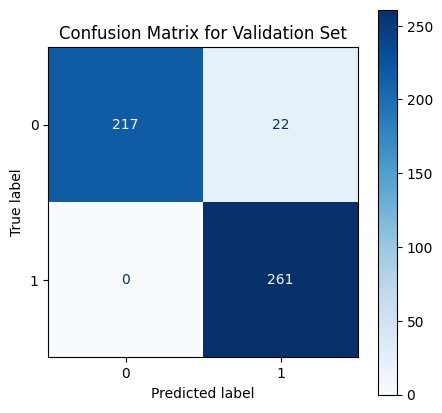

Test Accuracy: 0.964


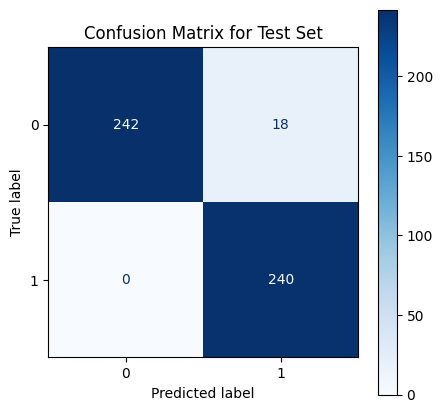

In [15]:
# Initialize wandb API client and download the model artifact
api = wandb.Api()
artifact_full_path = "nlp_janninemeier/project4_JM/model-divine-sweep-2:v0"
artifact = api.artifact(artifact_full_path, type='model')
artifact_dir = artifact.download()

evaluate_model(eval_dataset, test_dataset, compute_metrics, artifact_dir)

#### Anagram Large
Best learning rate configuration was 1e-5. This is the red run in wandb.

wandb: Downloading large artifact model-major-sweep-2:v0, 417.68MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:1.0


Validation Accuracy: 0.992


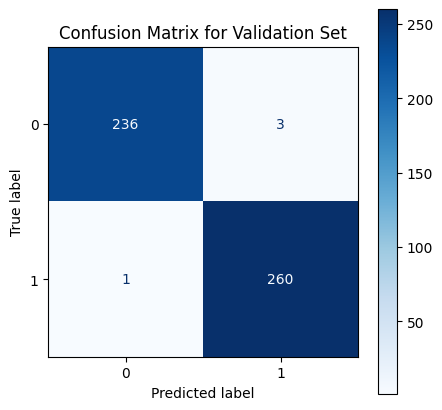

Test Accuracy: 0.996


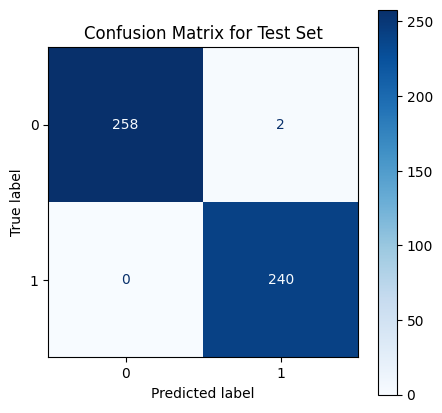

In [17]:
# Initialize wandb API client and download the model artifact
api = wandb.Api()
artifact_full_path = "nlp_janninemeier/project4_JM/model-major-sweep-2:v0"
artifact = api.artifact(artifact_full_path, type='model')
artifact_dir = artifact.download()

evaluate_model(eval_dataset, test_dataset, compute_metrics, artifact_dir)

## Interpretation

#### Winogrande
- Validation accuracy: 0.553 (last project 0.509)
- Test accuracy: 0.662 (last project 0.500)

In the last project my model was not showing any signs of learning as not even the train accuracy improved over time. This time I see some improvement so it is finally (a bit) better than guessing, but still it doesn't perform well. I tried out many learning rates and found that I got the best scores at 1e-5, even though the loss curve for validation does not look very promising as it goes up meaning the model is overfitting and therefore gets worse at predicting new unseen data. The other learning rates did not really show any signs of learning. As I talked to other students and they were also able to get a higher score in this task I guess it could be that the task is still just too complex for the specific model I chose and maybe others would perform better (eg. roBERTa or BERTs AutoModelForSequence). But in conclusion I'm happy to finally beat the 50% after many weeks of trying :D.

#### Anagram Small
- Validation accuracy: 0.956 (last project 0.564)
- Test accuracy: 0.964 (last project 0.536)

Different than in my last projects I was already able to get great results with the smaller dataset. Even though I get a high accuracy early on I was not able to reach above the 95% for the validation set when training for longer time. I reached the 100% for the train set but this has to do with overfitting. A low learning rate of 1e-6 was the best fit here.

#### Anagram Large
- Validation accuracy: 0.992 (last project 0.999)
- Test accuracy: 0.996 (last project 0.972)

For the big dataset I see that the model achieves even better test results than in my last project. Other than for the small dataset here I was able to steadly but slowly improve my accuracies (after the spike to 96% early on) and after long time of training I reach over 99%. Both training and validation loss/accuracies look as they should. A low learning rate of 1e-5 was the best fit here. I would say with this test accuracy the model was able to succesfully solve this task.


Same as in the last projects I used ChatGPT to help me clean up my code. 